# ICS笑传之抄抄榜

### Flag 1

你肯定很好奇这一大坨perl源码是怎么和ruby后端交互的。考虑Autolab支持各种各样的评测，肯定使用的使用比较通用的数据交互格式，而不是parse命令行输出。点开评测日志，注意到，`driver.pl`最后会输出一个JSON字符串：

```perl
if ($autograded) {
    $autoresult = "{ \"scores\": {\"Correctness\":$tpoints}, \"scoreboard\": [$tpoints, $tops";
    foreach $name (sort {$puzzle_number{$a} <=> $puzzle_number{$b}} 
                   keys %puzzle_number) {
        $autoresult .= ", $puzzle_p_ops{$name}";
    }   
    $autoresult .= "]}";
    print "$autoresult\n";
    print "{ \"scores\": {\"Correctness\":80}, \"scoreboard\": [80, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}\n"
}
```

那如果我们改一下呢：

```perl
if ($autograded) {
    print "{ \"scores\": {\"Correctness\":80}, \"scoreboard\": [80, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}\n"
}
```

成了！

### Flag 2

Flag 2 肯定是让我们来做未授权访问，想办法Take Over UID=1 的账户。


还是老起手，先看看API列表：

```ruby
# config/routes.rb#L93
  resources :users do
    get "admin"
    get "download_all_submissions", on: :member
    get "github_oauth", on: :member
    get "lti_launch_initialize", on: :member
    post "lti_launch_link_course", on: :member
    post "github_revoke", on: :member
    get "github_oauth_callback", on: :collection
    match "update_password_for_user", on: :member, via: [:get, :put]
    post "change_password_for_user", on: :member
    patch "update_display_settings", on: :member
  end
```

这里有一个`update_password_for_user`，看起来很有意思。点开看看：

```ruby
  def update_password_for_user
    @user = User.find_by(id: params[:id])
    return if params[:user].nil? || params[:user].is_a?(String) || @user.nil?

    if params[:user][:password] != params[:user][:password_confirmation]
      flash[:error] = "Passwords do not match"
    elsif @user.update(password: params[:user][:password])
      flash[:success] = "Password changed successfully"
      redirect_to(root_path)
    else
      flash[:error] = "Password #{@user.errors[:password][0]}"
    end
  end
```

它的功能是更新用户密码。但是这里有一个问题，它没有检查当前用户是否有权限修改这个用户的密码。理论上Devise会生成一个Reset Token，但是它并没有校验。我们可以直接修改`params[:id]`为1，然后试试：

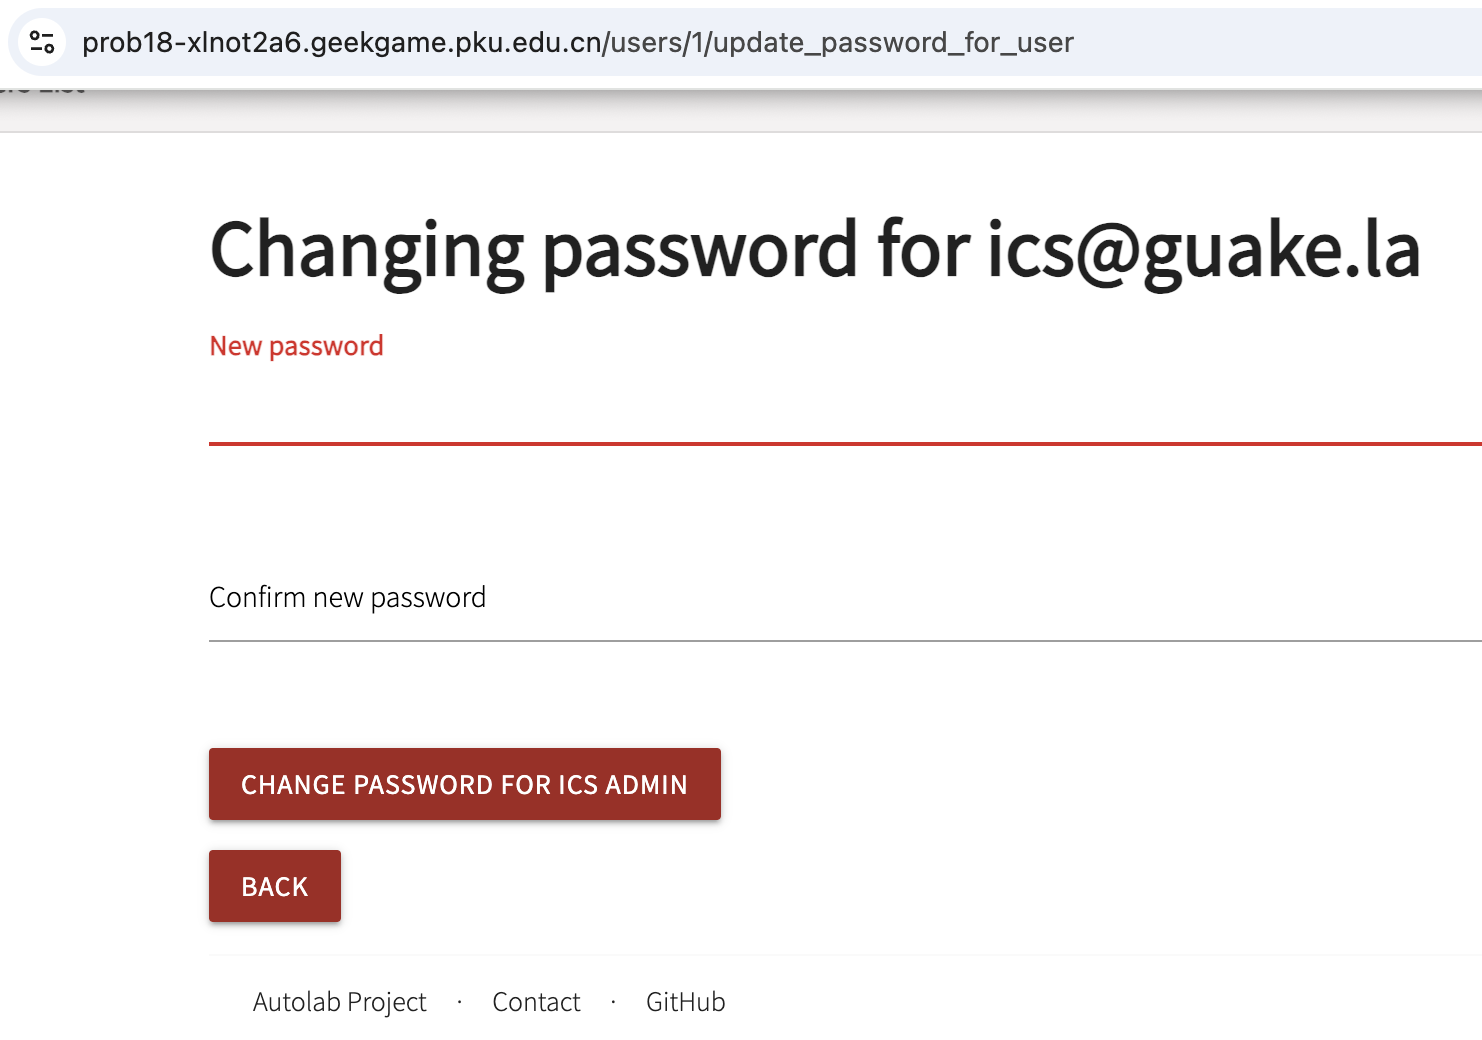

成了！修改密码直接登录完事。